# Reinforcement Learning in Wumpus World: Navigating Hazards and Maximizing Rewards

Here we train the agent in the wumpus world environment using Q-learning to optimize it's movement path

In [7]:
# 1. for creating numpy arrays for state and action spaces
import numpy as np
# for generating random action
import random

In [8]:
class WumpusWorldEnv:
    def __init__(self, grid_size=4):
        self.grid_size = grid_size
        self.reset()

    def reset(self):
        self.agent_pos = [0, 0]
        self.gold_pos = [self.grid_size - 1, self.grid_size - 1]
        self.wumpus_pos = [random.randint(1, self.grid_size - 1), random.randint(1, self.grid_size - 1)]
        self.pits = [
            [random.randint(1, self.grid_size - 1), random.randint(1, self.grid_size - 1)]
            for _ in range(self.grid_size - 2)
        ]
        self.done = False
        return self.agent_pos

    def step(self, action):
        if action == 0:  # up
            self.agent_pos[0] = max(self.agent_pos[0] - 1, 0)
        elif action == 1:  # down
            self.agent_pos[0] = min(self.agent_pos[0] + 1, self.grid_size - 1)
        elif action == 2:  # left
            self.agent_pos[1] = max(self.agent_pos[1] - 1, 0)
        elif action == 3:  # right
            self.agent_pos[1] = min(self.agent_pos[1] + 1, self.grid_size - 1)

        reward = -1  # penalty for each move
        if self.agent_pos == self.gold_pos:
            reward = 1000
            self.done = True
        elif self.agent_pos == self.wumpus_pos or self.agent_pos in self.pits:
            reward = -1000
            self.done = True

        return self.agent_pos, reward, self.done

    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size), dtype=str)
        grid[:, :] = '.'
        grid[tuple(self.gold_pos)] = 'G'
        grid[tuple(self.wumpus_pos)] = 'W'
        for pit in self.pits:
            grid[tuple(pit)] = 'P'
        grid[tuple(self.agent_pos)] = 'A'
        print(grid)

In [9]:
env = WumpusWorldEnv(grid_size=4)

In [10]:
# implementing Q-learning
def train_agent(env, episodes=500, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995):
    q_table = np.zeros((env.grid_size, env.grid_size, 4))  # 4 actions, that have been listed in the previous cells
    rewards_per_episode = {}
    epsilons = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        # epsilon-greedy algorithm implementation
        while not done:
            if random.uniform(0, 1) < epsilon:
                action = random.randint(0, 3)

            else:
                action = np.argmax(q_table[state[0], state[1], :])

            next_state, reward, done = env.step(action)
            total_reward += reward

            #Q-value update
            old_value = q_table[state[0], state[1], action]
            next_max = np.max(q_table[next_state[0], next_state[1], :])
            q_table[state[0], state[1], action] = old_value + alpha * (reward + gamma * next_max - old_value)

            state = next_state

        rewards_per_episode[episode] = total_reward
        epsilons.append(epsilon)
        epsilon = max(0.01, epsilon * epsilon_decay)  #Decay epsilon

    return rewards_per_episode, epsilons

In [11]:
rewards_per_ep, epsilons = train_agent(env)

In [12]:
import matplotlib.pyplot as plt

# plot the graph with moving window
def plot_rewards_per_episode(rewards_per_ep, environment_type, epsilons=None, window_size=10):
    episodes = np.array(list(rewards_per_ep.keys())).flatten()
    rewards = np.array(list(rewards_per_ep.values())).flatten()

    plt.figure(figsize=(10, 6))
    plt.plot(episodes, rewards, marker='o', linestyle='-', markersize=4, label='Rewards per Episode')

    if window_size > 1:
        moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        plt.plot(episodes[:len(moving_avg)], moving_avg, color='r', label=f'Moving Avg (window={window_size})')

    plt.title(f'Rewards per Episode {environment_type}', fontsize=20)
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Reward', fontsize=14)
    plt.grid(True)

    if epsilons:
        ax2 = plt.gca().twinx()
        ax2.plot(episodes, epsilons, color='g', alpha=0.6, linestyle='--', label='Epsilon')
        ax2.set_ylabel('Epsilon', fontsize=14)
        ax2.tick_params(axis='y', labelsize=12)

    plt.legend()
    plt.tight_layout()
    plt.show()

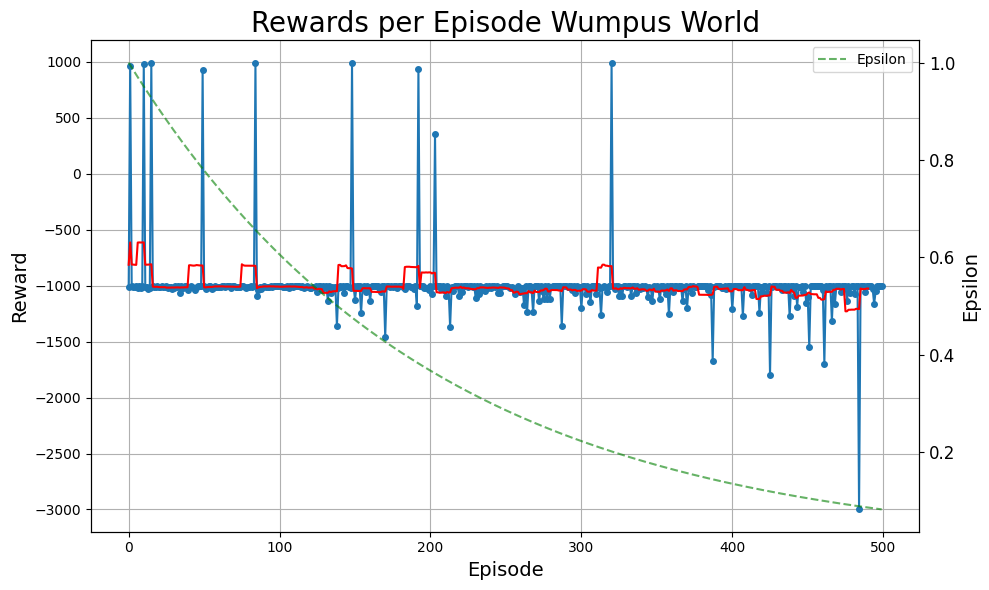

In [13]:
#Plot results for the Wumpus World
plot_rewards_per_episode(rewards_per_ep, "Wumpus World", epsilons)